In [1]:
import io

import numpy as np
import numpy.testing
import requests
import xarray

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import GPy
import openeo
import pandas as pd
from openeo.rest.conversions import timeseries_json_to_pandas
from datetime import datetime

import time

### Retrieve data

In [2]:
def test_mogpr_realdata():
    ds = xarray.load_dataset(io.BytesIO(requests.get("https://artifactory.vgt.vito.be/testdata-public/malawi_sentinel2.nc",stream=True).content))
    some_index = (ds.B04 - ds.B02) / (ds.B04 + ds.B02)
    return some_index

In [3]:
da = test_mogpr_realdata()
# Convert to dataset in preparation of several signals
ds = da.to_dataset(name = 'NDVI')
ds

<xarray.Dataset>
Dimensions:  (t: 46, x: 113, y: 53)
Coordinates:
  * t        (t) datetime64[ns] 2020-01-24 2020-04-03 ... 2020-12-09 2020-12-24
  * x        (x) float64 5.887e+05 5.887e+05 5.887e+05 ... 5.898e+05 5.898e+05
  * y        (y) float64 8.589e+06 8.589e+06 8.589e+06 ... 8.589e+06 8.589e+06
Data variables:
    NDVI     (t, y, x) float32 nan nan nan nan ... 0.06199 0.03431 0.01031

In [4]:
def mogpr_xarray(ds, tstep):
    
    """
    ds(xarray.dataset): input dataset
    tstep: time step for output
    """
    
    for pos_x in range(4):#len(ds.coords['x'].values)
        for pos_y in range(4):#len(ds.coords['y'].values)
            
            master_ind = 0
            nt = 1
            day_step = 15            
            
            time       = []
            data       = []
            time_str   = []
            var_names  = []
            
            for d in ds:
                y = ds[d][:, pos_y, pos_x].values
                x = ds[d]['t'].values
                                
                time_vec_num = np.asarray([pd.Timestamp(_).to_pydatetime().toordinal() for _ in x], dtype=np.float64) 
                time.append(time_vec_num)
                data.append(y)        
                var_names.append(d)
                
                #Plot input
                fig, ax = plt.subplots()                
                ax.plot(x, y, '.')
                ax.set_ylim([0, 1])
                fig.suptitle("Input for {} in position:({},{})".format(d, pos_x, pos_y))
                
            time_vec_min        = np.min(list(pd.core.common.flatten(time)))
            time_vec_max        = np.max(list(pd.core.common.flatten(time)))
            output_timevec      = np.array(range(int(time_vec_min), int(time_vec_max), tstep), dtype = np.float64)  
            output_time         = [datetime.fromordinal(int(_)) for _ in output_timevec]
            
            out_mean, out_std, out_qflag, out_model = mogpr_1D(data[:], time[:], master_ind, output_timevec, nt)
            mogpr_mean_out_df, df_mogpr_out_std = post_MOGPR_1D(out_mean, out_std, output_time, var_names)
            
            # Plot results
            plot = mogpr_mean_out_df.plot(marker='.', linestyle='--')
            fig = plot.get_figure()
            ax = fig.gca()
            ax.set_ylim([0, 1])
            fig.suptitle("Output for position:({},{})".format(pos_x, pos_y))
            ax.get_legend().remove()
            

def mogpr_1D(data_in, time_in, master_ind, output_timevec, nt, trained_model=None):
    """
    Function performing the multioutput gaussian-process regression at pixel level for gapfilling purposes
    
    Args:
        data_in (list): List of numpy 1D arrays containing data to be processed
        time_in (list): List of numpy 1D arrays containing the (ordinal)dates of each variable in the time dimension
        master_ind (int): Index identifying the Master output
        output_timevec (array) : Vector containing the dates on which output must be estimated
        nt [int]: # of times the GP training must be performed (def=1)
    Returns:
        a tuple
        (out_mean, out_std, out_qflag, out_model) where:
        - out_mean_list (array): List of numpy 1D arrays containing mean value of the prediction at pixel level
        - out_std_list (array): List of numpy 1D arrays containing standard deviation of the prediction at pixel level
        - out_qflag (bool): Quality Flag for any numerical error in the model determination
        - out_model (Object): Gaussian Process model for heteroscedastic multioutput regression
    """    
    # Number of outputs
    noutputs = len(data_in)
    # Number of output samples
    outputs_len = output_timevec.shape[0]
    
    out_mean  = []
    out_std   = []
    out_model = []
    
    X_vec = []
    Y_vec = []
    Y_mean_vec = []
    Y_std_vec  = []

    out_qflag = True
    
    #Variable is initialized to take into account possibility of no valid pixels present
    for ind in range(noutputs):           
        
        out_mean.append(np.full(outputs_len,np.nan))
        out_std.append(np.full(outputs_len,np.nan))
        
        X_tmp  = time_in[ind]
        Y_tmp  = data_in[ind]
        X_tmp  = X_tmp[~np.isnan(Y_tmp), np.newaxis]
        Y_tmp  = Y_tmp[~np.isnan(Y_tmp), np.newaxis]        
        X_vec.append(X_tmp)
        Y_vec.append(Y_tmp)
        del X_tmp,Y_tmp
        
        # Data Normalization        
        Y_mean_vec.append(np.mean(Y_vec[ind])) 
        Y_std_vec.append(np.std(Y_vec[ind]))
        Y_vec[ind] = (Y_vec[ind]-Y_mean_vec[ind])/Y_std_vec[ind]          
        
    if np.size(Y_vec[master_ind])>0:        
        # Multi-output train and test sets
        Xtrain = X_vec
        Ytrain = Y_vec       
        
        Yp = np.zeros((outputs_len, noutputs))
        Vp = np.zeros((outputs_len, noutputs))
        
        for i_test in range(nt):
            try:
                if trained_model is None:
                    # Kernel
                    K = GPy.kern.Matern32(input_dim=1)
                    # Linear coregionalization 
                    LCM = GPy.util.multioutput.LCM(input_dim=1, num_outputs=noutputs, kernels_list=[K]*noutputs, W_rank=1)        
                    out_model = GPy.models.GPCoregionalizedRegression(Xtrain, Ytrain, kernel=LCM.copy())  
                    out_model.optimize()                    
                else: 
                    out_model = trained_model

            except:
                out_qflag=False
                continue

            for out in range(noutputs):                
                newX =  output_timevec[:, np.newaxis]
                newX = np.hstack([newX, out * np.ones((newX.shape[0], 1))])

                noise_dict = {'output_index': newX[:, -1:].astype(int)} 
                # Prediction
                Yp[:, None, out], Vp[:, None, out] = out_model.predict(newX, Y_metadata=noise_dict)                        

                if i_test==0:
                    out_mean[out][:, None] = (Yp[:,None, out]*Y_std_vec[out]+Y_mean_vec[out])/nt       
                    out_std[out][:, None]  = (Vp[:,None, out]*Y_std_vec[out])/nt       
                else:                
                    out_mean[out][:, None] = out_mean[out][:, None] + (Yp[:, None, out]*Y_std_vec[out]+Y_mean_vec[out])/nt       
                    out_std[out][:, None]  = out_std[out][:, None]  + (Vp[:, None, out]*Y_std_vec[out])/nt        

            del Yp,Vp
            
    # Flatten the series    
    out_mean_list = []
    out_std_list = []
    for ind in range(noutputs):
        out_mean_list.append(out_mean[ind].ravel())
        out_std_list.append(out_std[ind].ravel())    
        
    return  out_mean_list, out_std_list, out_qflag, out_model 

def post_MOGPR_1D(out_mean_list, out_std_list, output_dates, var_names):
    """
    Post-processing MOGPR to built the output dataframes

    Args:
      out_mean_list [array] : List of numpy arrays containing the predicted mean.
      out_std_list [array] :List of numpy arrays containing the uncertainty.
      output_dates [array] : Dates of the outputs corresponding to out_mean, out_std
      var_names [array] : Names of the input/output signals
      
    Returns:
      df_mogpr_out_mean [Dataframe] : Predicted mean(with index)
      df_mogpr_out_std [Dataframe]  : Uncertainty(with index)
    """       
    # Predicted mean
    df_mogpr_out_mean = pd.DataFrame(np.column_stack(out_mean_list), columns = var_names)
    df_mogpr_out_mean.index = output_dates
    
    # Uncertainties
    df_mogpr_out_std = pd.DataFrame(np.column_stack(out_std_list), columns = var_names)
    df_mogpr_out_std.index = output_dates    
    
    return df_mogpr_out_mean, df_mogpr_out_std

 C:\Users\1\anaconda3\envs\AI4FOOD36\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


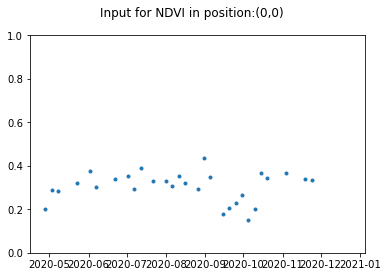

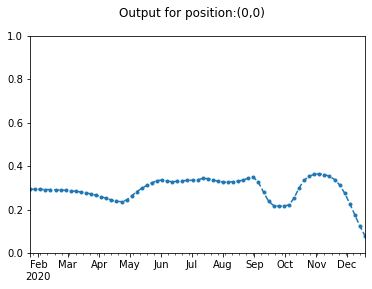

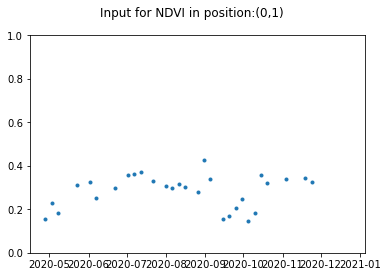

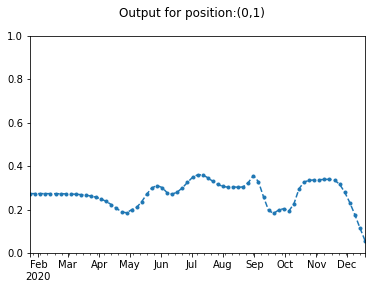

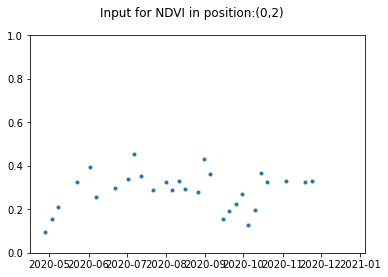

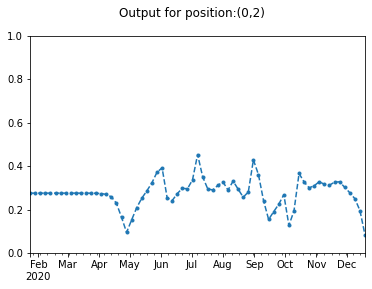

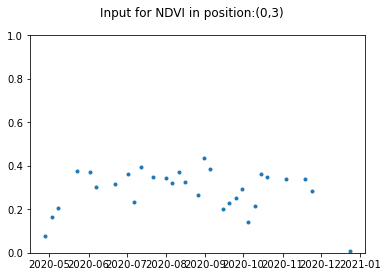

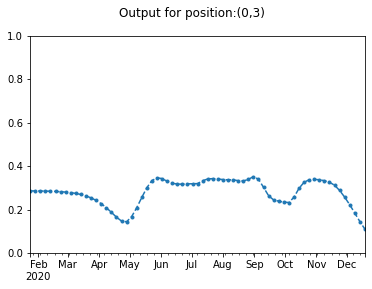

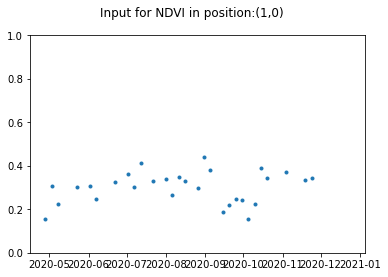

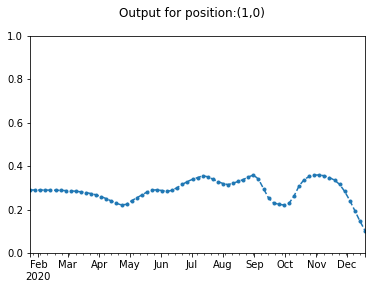

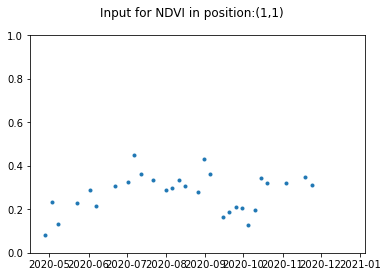

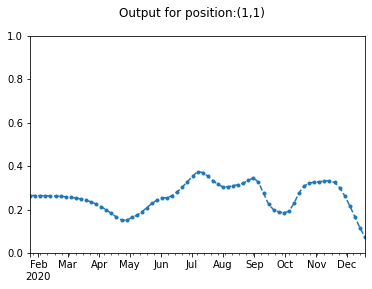

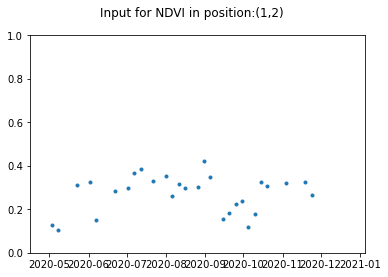

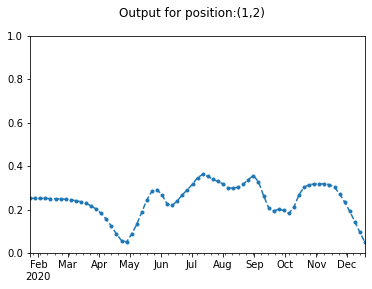

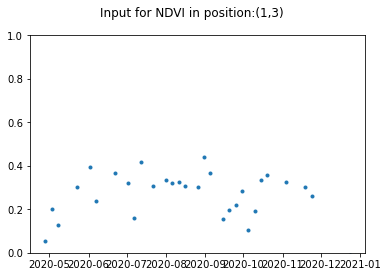

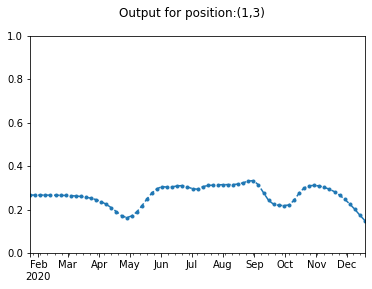

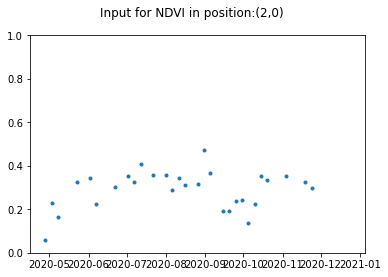

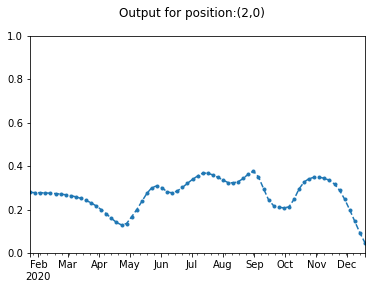

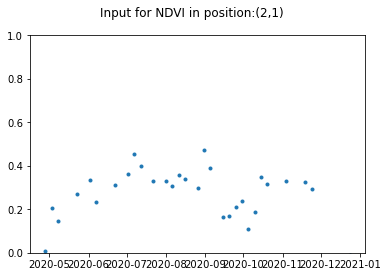

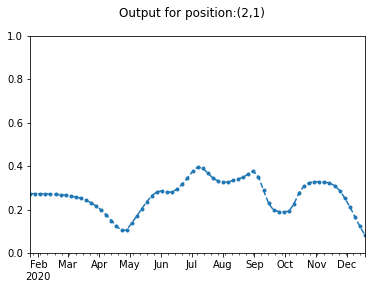

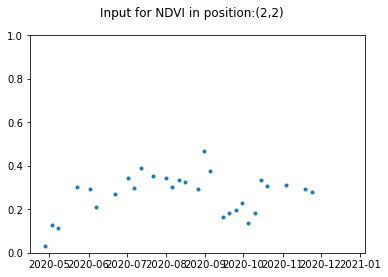

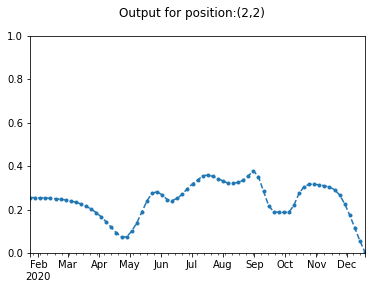

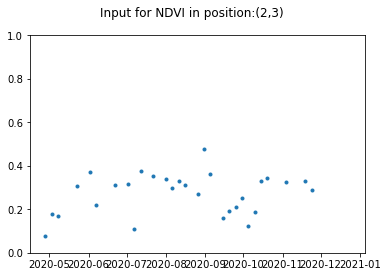

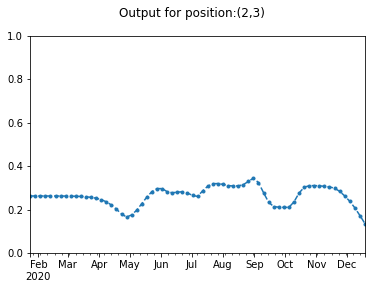

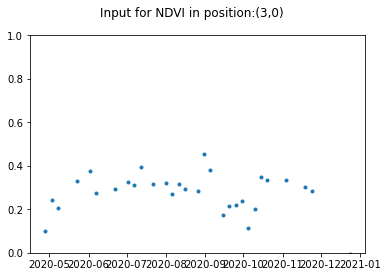

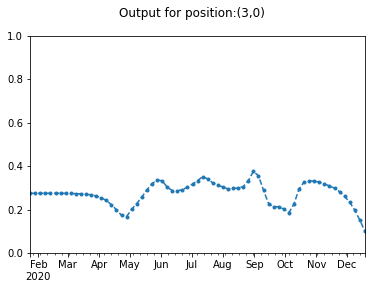

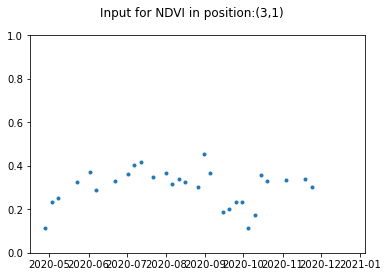

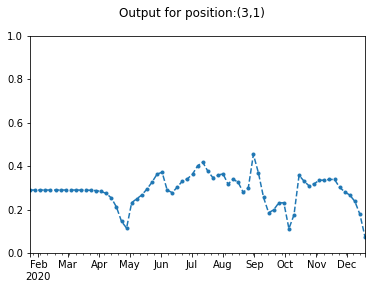

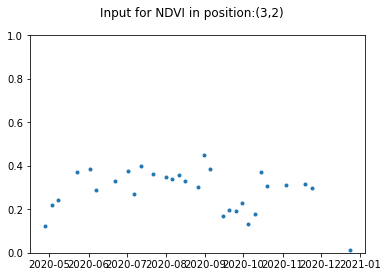

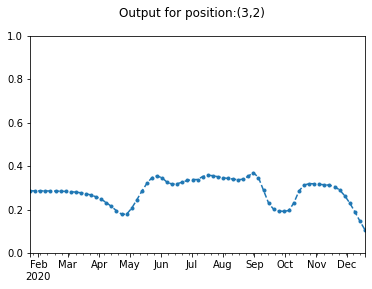

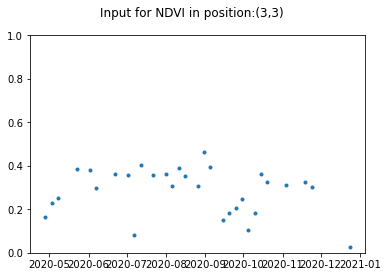

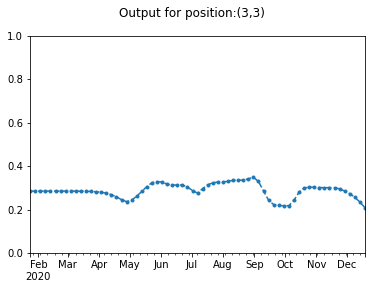

In [5]:
mogpr_xarray(ds, 5)